In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim
import itertools

from sklearn import manifold, cluster, preprocessing
import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [ ]:
def maximum_qq_size(arr, max_thr=None, alpha=0.15, iqr_factor=1.25, ignore=0):
    foo = arr[arr > ignore]
    if max_thr is None:
        max_thr = np.max(foo)
    q1, q3 = np.quantile(foo, [alpha, 1-alpha])
    
    return min([q3 + iqr_factor*(q3 - q1) , max_thr])

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.05

marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#f0e442', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
weight = np.load(ksrc + sample + '_border_weights.npy', allow_pickle=True)
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))

transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
wall[tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

transfocus

In [17]:
level = 'sup'
normtype = 'both'
bw = 20
stepsize = 3

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)
foo = [bw, stepsize, level.title(), normtype.title(), sigma, pers_w]
Bname = 'KDE bandwidth {}, stepsize {}. {}level persistence. {} normalized. PIs $\sigma = {}$. Weighted by $n^{{{}}}$.'.format(*foo)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

method = 'PCA'
csvfilenames = glob(dsrc + '*{}*.csv'.format(method.lower()))

In [225]:
csvidx = 0
embedding = pd.read_csv(csvfilenames[csvidx], index_col=0)
pca = embedding.iloc[:,:2].values

pi_params, method_params = os.path.splitext(os.path.split(csvfilenames[csvidx])[1])[0].split('_{}'.format(method.lower()))
pi_params = pi_params.split('_')
SCALE = int(pi_params[0][5:])
sigma = float(pi_params[3])
if int(sigma) == sigma:
    sigma = int(sigma)
pers_w = float(pi_params[4])
if int(pers_w) == pers_w:
    pers_w = int(pers_w)
pixel_size = int(pi_params[5])
print(SCALE, sigma, pers_w, pixel_size, sep='\t')
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

16	1	1	1


In [30]:
orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
diags, nzcumsum, nzmask = utils.reduce_num_of_diagrams(orig_diags, rescale, focus_dim, normtype, minlife=minlife, keepall=False)
lt_coll, maxbirth = utils.birthdeath_to_flattened_lifetime(diags, nzcumsum[-1])

Initial number of life-birth pairs	: 56757

No. of diagrams s.t. H_k had the most persistent component
H_0:	5473 [ 94.2% ]
H_1:	335 [ 5.8% ]
H_2:	0 [ 0.0% ]

Will focus just on dimension k = 0

Non-zero diagrams:	4887
Compared to all diagrams:	5808	[84.14%]


# Bring in persistence images to the party

In [31]:
pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
pi_extent = [ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]
img = np.asarray(pimgr.transform(lt_coll, skew=False))
img[img < 0] = 0
print(embedding.shape, img.shape)

In [215]:
steps = 1
llim = int(np.floor(pca[:,0].min()))
rlim = int(np.ceil(pca[:,0].max()))

blim = int(np.floor(pca[:,1].min()))
tlim = int(np.ceil(pca[:,1].max()))
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(3*steps)

blim, llim = np.min(grid[minmask], axis=0)
tlim, rlim = np.max(grid[minmask], axis=0)
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
argmin = np.argmin(dists, axis=1)
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(3*steps)
reps = argmin[minmask]

vmax = np.quantile(img[reps][img[reps] > 0], 0.99)
nrow = int((tlim - blim)*steps)+1
ncol = int((rlim - llim)*steps)+1

-1 4 6 -3
0.0 2.0 5.0 -2.0


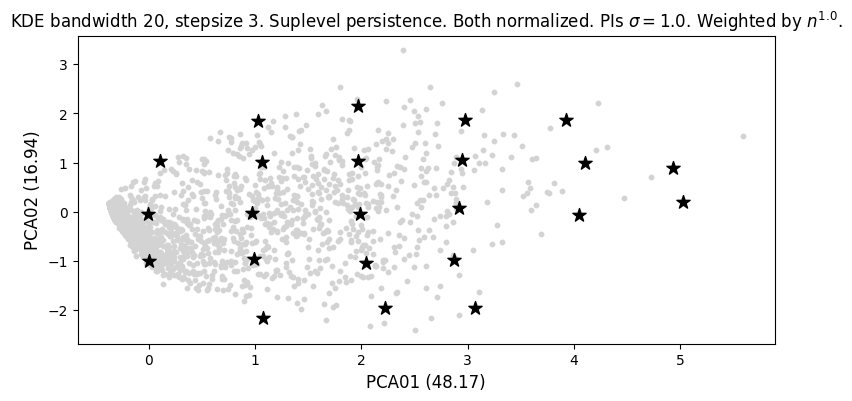

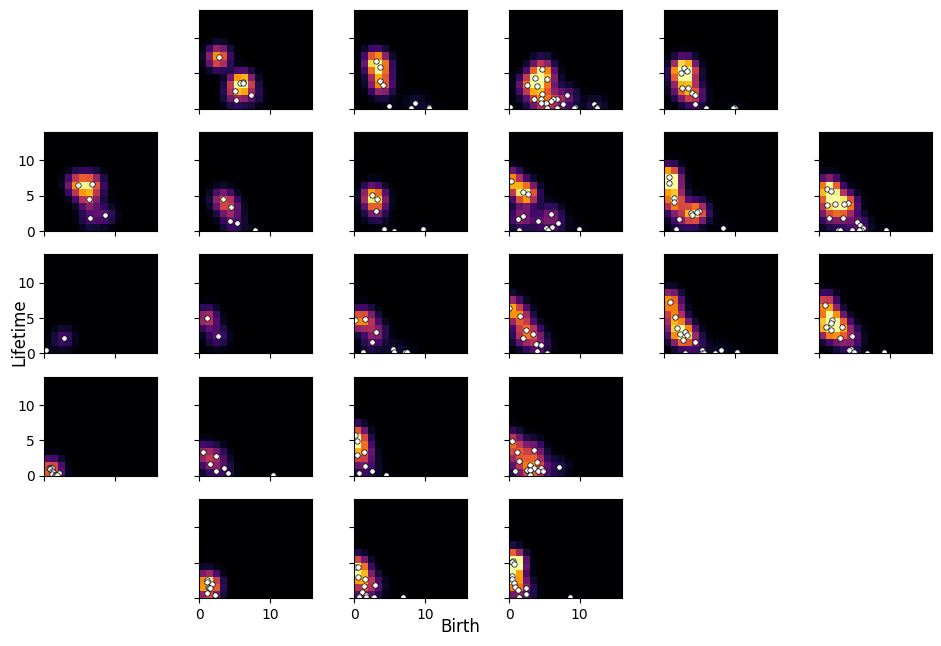

In [301]:
fig, ax = plt.subplots( 1,1, figsize=(1.5*ncol, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
ax[i].scatter(pca[reps,0], pca[reps,1], c='k', marker='*', s=100, alpha=1, zorder=2)
ax[i].set_xlabel(embedding.columns[0], fontsize=fs)
ax[i].set_ylabel(embedding.columns[1], fontsize=fs)
filename = dsrc + bname + method.lower() + '_gridded'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.35*nrow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    k = reps[i]
    ax[j].imshow(img[k].T, cmap='inferno', vmin=0, vmax=vmax, origin='lower', extent=extent)
    ax[j].scatter(lt_coll[k][:,0], lt_coll[k][:,1], c='w', marker='o', s=15, edgecolor='k', linewidth=0.5)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

fig.supxlabel('Birth', fontsize=fs, y=0.05)
fig.supylabel('Lifetime', fontsize=fs, x=0.05)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_PI_sample'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [284]:
KDE = [None for _ in range(len(reps))]
hcells = [None for _ in range(len(reps))]
hcoords = [None for _ in range(len(reps))]
hextent = [None for _ in range(len(reps))]
hzhist = [None for _ in range(len(reps))]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, cextent, zmax, stepsize)
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    coords = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    
    w = weight[tcumsum[embedding.loc[reps[i], 'gene_ID']] : tcumsum[embedding.loc[reps[i], 'gene_ID']+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = cextent
    hcoords[i] = coords
    hzhist[i] = zhist

pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
for cell in hcells:
    cell[pxbar] = 0

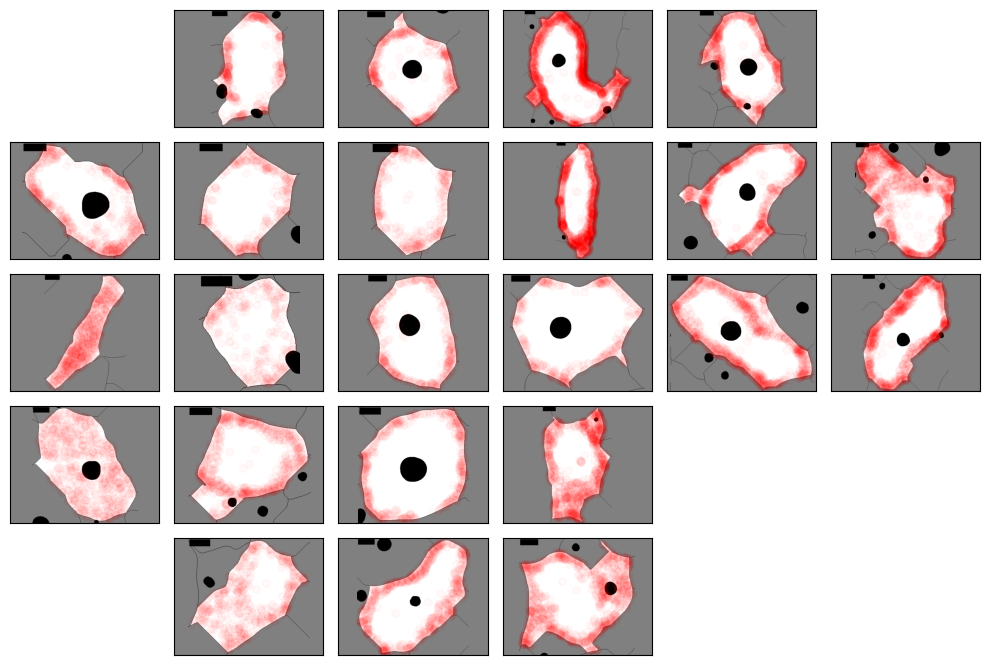

In [288]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.35*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hcells[i], cmap='binary_r', origin='lower', extent=hextent[i], vmin=0, vmax=2);
    ax[j].scatter(hcoords[i][0], hcoords[i][1], color='red', marker='o', alpha=0.025, s=30)
    ax[j].set_facecolor('#808080')
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_cell_sample'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [286]:
hkdes= [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
kx = np.quantile( np.hstack([ hkdes[i][hkdes[i] > 1e-20] for i in range(len(hkdes)) ]), 0.99)
hzlevel = np.array(list(map(np.argmax, hzhist)))

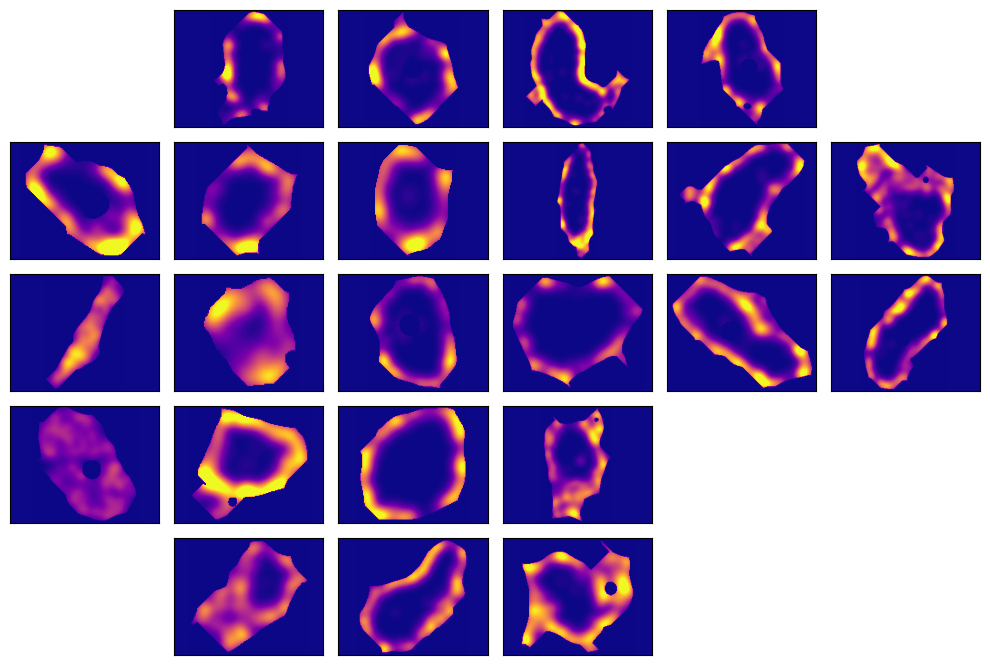

In [313]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.35*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap='plasma', vmin=0, vmax=kx, zorder=1)
    ax[j].set_facecolor('#0d0887')
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_kde_sample'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [398]:
pcnum = 1
pcastd = np.zeros(len(Genes))
for i in range(len(pcastd)):
    pcastd[i] = np.std(pca[embedding['gene_ID'] == Genes[i], pcnum])
gidx = np.argmax(pcastd)

gidx = 0
pmask = embedding['gene_ID'] == Genes[gidx]
cellloc = metacell.loc[ Cells[ nzmask[gidx] ], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values
vmax = maximum_qq_size(pca[pmask, pcnum], alpha=0.25, iqr_factor=1.5, ignore=blim)
minx = np.argmin( pca[embedding['gene_ID'] == Genes[gidx], pcnum] )
maxx = np.argmax( pca[embedding['gene_ID'] == Genes[gidx], pcnum] )

Genes[gidx]

85

../infected_focus_summer24/D2/G6_suplevel_both_step3_bw20/scale16_-_PI_1_1_1_pca01_GLYMA_17G195900


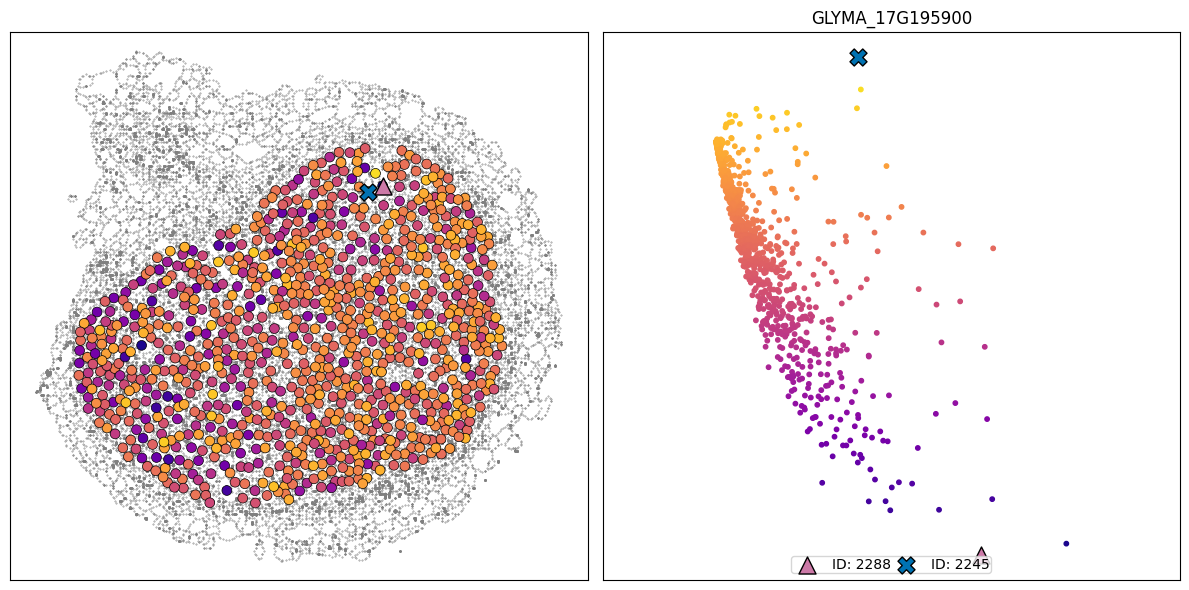

In [401]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(cellloc[:,0], cellloc[:,1], c=pca[pmask, pcnum], marker='o', cmap='plasma',
              edgecolor='black', linewidth=0.5, zorder=2, s=50, vmax=vmax)
for j in [minx, maxx]:
    ax[i].scatter(cellloc[j,0], cellloc[j,1], color=color[j%7], marker=marker[j%8], zorder=5, s=150, edgecolor='k', linewidth=1)

i += 1
ax[i].scatter(*(pca[pmask].T), c=pca[pmask,pcnum], marker='o', s=10, alpha=1, zorder=1, vmax=vmax, cmap='plasma')
for j in [minx, maxx]:
    ax[i].scatter(pca[pmask][j,0], pca[pmask][j,1], color=color[j%7], marker=marker[j%8], zorder=4, s=150,
                 edgecolor='k', linewidth=1, label = 'ID: {}'.format(int(cellloc[j,-1])) )

ax[i].legend(ncols=3, borderpad=0.1, labelspacing=0.1, columnspacing=0.1, loc='lower center')
#ax[i].set_xlim(pp[:,0].min()-1, pp[:,0].max()+1)
#ax[i].set_ylim(pp[:,1].min()-1, pp[:,1].max()+1)
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = dsrc + bname + method.lower() + '{:02d}_{}'.format(pcnum, transcriptomes[Genes[gidx]])
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# PCA differences

In [367]:
gi, gj = 0,5


pcastd = np.zeros(len(Genes))
for i in range(len(pcastd)):
    pcastd[i] = np.std(pca[embedding['gene_ID'] == Genes[i], pcnum])
gidx = np.argmax(pcastd)

gidx = 0
pmask = embedding['gene_ID'] == Genes[gidx]
cellloc = metacell.loc[ Cells[ nzmask[gidx] ], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values
vmax = maximum_qq_size(pca[pmask, pcnum], alpha=0.25, iqr_factor=1.5, ignore=blim)
minx = np.argmin( pca[embedding['gene_ID'] == Genes[gidx], pcnum] )
maxx = np.argmax( pca[embedding['gene_ID'] == Genes[gidx], pcnum] )

Genes[gidx]

-0.36642173

4.1203121375

# Explore